In [1]:
#!unzip ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import io
import cv2



---



---

Person detector


In [3]:
# Model
person_detector = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5n - yolov5x6, custom

/usr/local/lib/python3.7/dist-packages/torch/hub.py:267: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  "You are about to download and run code from an untrusted repository. In a future release, this won't "
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev

  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 




---



---

Keypoints dectector


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/single-person-pose-estimation')
%matplotlib inline

In [5]:
from configs import default_config as cfg
from utilities.data_utils import *
from utilities.visualization_utils import *
from dataset_builder import DatasetBuilder
from demo import *

In [6]:
keypoints_detector = tf.keras.models.load_model('/content/drive/MyDrive/single-person-pose-estimation/trained_models/S-4_E-120_OPT-Adam_L-IOU')



---

---





In [ ]:
ds_builder = DatasetBuilder(cfg)

Train dataset with 66 tfrecords and 134214 examples.
Valid dataset with 3 tfrecords and 5647 examples.


In [ ]:
ds_train, ds_valid = ds_builder.build_datasets()

In [ ]:
images_batch, heatmaps_batch = next(iter(ds_valid))

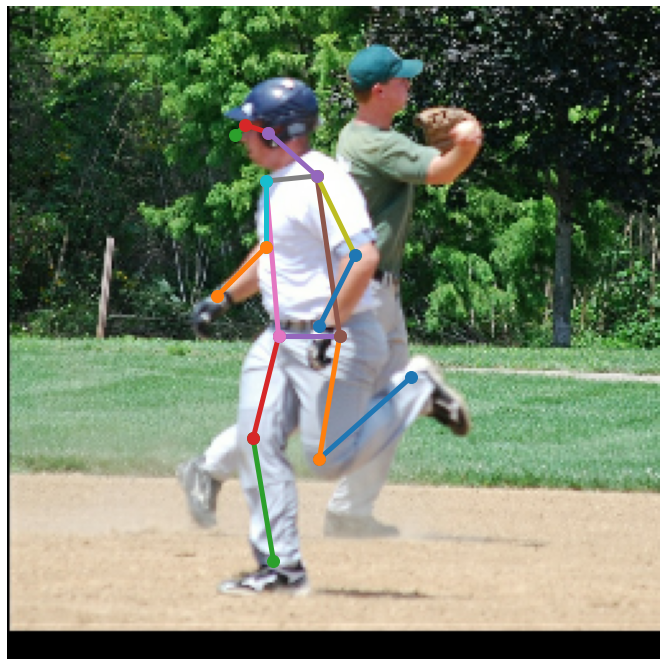

In [ ]:
detect_single_person(images_batch[3], keypoints_detector,  keypoint_conf_threshold=0.5)



---



---



In [ ]:
def detect_multiple(image, person_detector, keypoints_detetor, max_num_ppl = 6, human_conf_thres=1e-6, keypoints_conf_thres=1e-6):
  
  '''
    Detect multiple people in one image
  '''
  ## Read the image, yolov5 does not accept tf Tensor, image must be RGB cv image
  ## Stage 1: person_detector
  # Predict
  stage1_result = person_detector(image)
  # Convert to pandas DataFrame, only take person category
  df = stage1_result.pandas().xyxy[0]
  human_df = person_df = df[(df['name']=='person') & (df['confidence'] > human_conf_thres)]
  # Get bounding boxes
  bboxes = []
  xmins = human_df['xmin'].values
  ymins = human_df['ymin'].values
  xmaxs = human_df['xmax'].values
  ymaxs = human_df['ymax'].values
  for xmin, ymin, xmax, ymax in zip(xmins, ymins, xmaxs, ymaxs):
    bboxes.append((xmin, ymin, xmax-xmin, ymax-ymin))
  # Restrict number of ppl in one picture
  bboxes = bboxes[:max_num_ppl]


  ## Stage 2: keypoints_detector
  # Crop to bboxes
  tf_image = tf.convert_to_tensor(image)
  tf_image = tf.image.convert_image_dtype(tf_image, dtype=tf.float32) # safe conversion
  transformed_images = []
  transformed_bboxes = []
  for bbox in bboxes:
    new_bbox = transform_bbox_square(bbox, cfg.BBOX_SCALE)
    new_image = crop_and_pad(tf_image, new_bbox)
    new_image = tf.image.resize(new_image, (cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH))
    transformed_bboxes.append(new_bbox)
    transformed_images.append(new_image)
  # Predict
  pred = keypoints_detetor.predict(tf.convert_to_tensor(transformed_images)) # return a list
  keypoints_list = []
  for hms in pred[-1]:
    keypoints_list.append(heatmaps_to_keypoints_v2(hms, keypoints_conf_thres))
    
  ## Stage 3: visualization
  plt.figure(figsize=(12,12))
  plt.imshow(image)
  for keypoints, bbox in zip(keypoints_list, transformed_bboxes):
      xs = (keypoints[:, 0]/cfg.LABEL_WIDTH)
      ys = (keypoints[:, 1]/cfg.LABEL_HEIGHT)

      # extracting pairs
      xs1, ys1 = xs[cfg.COCO_SKELETON[:,0]], ys[cfg.COCO_SKELETON[:,0]]
      xs2, ys2 = xs[cfg.COCO_SKELETON[:,1]], ys[cfg.COCO_SKELETON[:,1]]
      for x1, y1, x2, y2 in zip(xs1, ys1, xs2, ys2):
        if x1 and y1 and x2 and y2:
           plt.plot((x1*bbox[2] + bbox[0], x2*bbox[2] + bbox[0]), (y1*bbox[3] + bbox[1], y2*bbox[3] + bbox[1]), marker='o', linewidth=5, markersize=1)

  plt.axis('off')


[[       28.5       12.25     0.84382]
 [       29.5       11.25     0.83877]
 [         28       11.25     0.91833]
 [      32.25          12     0.83004]
 [          0           0           0]
 [       35.5       17.25     0.82579]
 [         26       18.25     0.84413]
 [      39.25          24     0.83431]
 [       23.5       24.25     0.83886]
 [       40.5       29.25     0.82872]
 [      23.25        28.5     0.84105]
 [      35.25          32     0.75841]
 [         29       32.25      0.7691]
 [      35.25          42      0.8386]
 [      30.25        42.5     0.86643]
 [      36.25          53     0.85036]
 [      31.25          52     0.89396]]


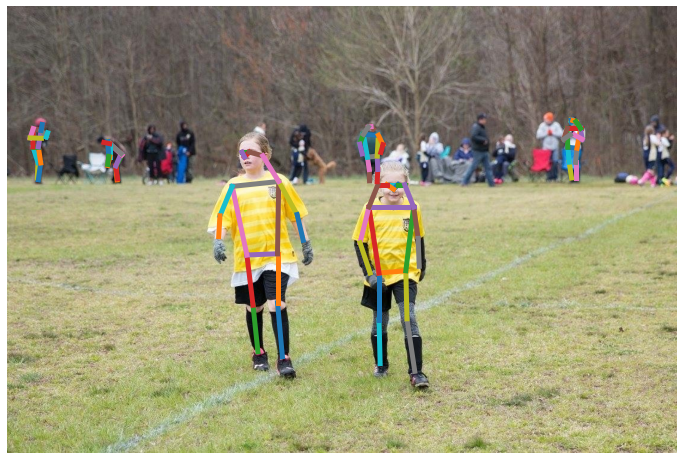

In [ ]:
image = cv2.imread('2_kids.jpg', cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
detect_multiple(image, person_detector, keypoints_detector)

In [7]:
class Demo:
  def __init__(self, person_detector, keypoints_detetor, cfg, max_num_ppl=6, person_conf_thres=1e-6, keypoints_conf_thres=1e-6):
    '''
      Detect multiple people in one image
    '''

    self.person_detector = person_detector
    self.keypoints_detetor = keypoints_detetor
    self.person_conf_thres = person_conf_thres
    self.keypoints_conf_thres = keypoints_conf_thres
    self.COCO_SKELETON = cfg.COCO_SKELETON
    self.max_num_ppl = max_num_ppl

  def detect(self, image):
    ## Read the image, yolov5 does not accept tf Tensor, image must be RGB cv image
    ## Stage 1: person_detector
    # Predict
    stage1_result = person_detector(image)
    # Convert to pandas DataFrame, only take person category
    df = stage1_result.pandas().xyxy[0]
    human_df = person_df = df[(df['name']=='person') & (df['confidence'] >self.person_conf_thres)]
    # Get bounding boxes
    bboxes = []
    xmins = human_df['xmin'].values
    ymins = human_df['ymin'].values
    xmaxs = human_df['xmax'].values
    ymaxs = human_df['ymax'].values
    for xmin, ymin, xmax, ymax in zip(xmins, ymins, xmaxs, ymaxs):
      bboxes.append((xmin, ymin, xmax-xmin, ymax-ymin))
    # Restrict number of ppl in one picture
    bboxes = bboxes[:self.max_num_ppl]

    ## Stage 2: keypoints_detector
    # Crop to bboxes
    tf_image = tf.convert_to_tensor(image)
    tf_image = tf.image.convert_image_dtype(tf_image, dtype=tf.float32) # safe conversion
    cropped_images = []
    transformed_bboxes = []
    for bbox in bboxes:
      new_bbox = transform_bbox_square(bbox, cfg.BBOX_SCALE)
      new_image = crop_and_pad(tf_image, new_bbox)
      new_image = tf.image.resize(new_image, (cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH))
      transformed_bboxes.append(new_bbox)
      cropped_images.append(new_image)
    # Predict
    keypoints_list = []
    if cropped_images:
      pred = self.keypoints_detetor.predict(tf.convert_to_tensor(cropped_images)) # return a list
      for hms in pred[-1]:
        kps = heatmaps_to_keypoints_v2(hms, self.keypoints_conf_thres)
        # Noremalize
        kps[:, 0] /= cfg.LABEL_WIDTH
        kps[:, 1] /= cfg.LABEL_HEIGHT
        keypoints_list.append(kps)
      
    self.image = image
    self.cropped_images = cropped_images
    self.original_bboxes = bboxes
    self.square_bboxes = transformed_bboxes
    self.keypoints_list = keypoints_list

  def show(self, figsize = (12, 12), show_bboxes=False, save=False):
    '''
      Show the orginal image with all predictions
      show_bboxes only show the bbox of person_dectector not transform ones
    '''
    fig = plt.figure(figsize=(figsize))
    plt.imshow(self.image)
    ax = plt.gca()
    for keypoints, bbox, old_bbox in zip(self.keypoints_list, self.square_bboxes, self.original_bboxes):
      xs = keypoints[:, 0]
      ys = keypoints[:, 1]
      # extracting pairs
      xs1, ys1 = xs[self.COCO_SKELETON[:,0]], ys[self.COCO_SKELETON[:,0]]
      xs2, ys2 = xs[self.COCO_SKELETON[:,1]], ys[self.COCO_SKELETON[:,1]]
      for x1, y1, x2, y2 in zip(xs1, ys1, xs2, ys2):
        if x1 and y1 and x2 and y2:
          plt.plot((x1*bbox[2] + bbox[0], x2*bbox[2] + bbox[0]), (y1*bbox[3] + bbox[1], y2*bbox[3] + bbox[1]), 
                    marker='o', linewidth=5, markersize=7)

      # Draw bboxes   
      if show_bboxes:
        rect = patches.Rectangle((old_bbox[0], old_bbox[1]), old_bbox[2], old_bbox[3], linewidth=3, 
                                  edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')
    plt.show()
    if save:
      plt.savefig('saved_file.png', bbox_inches='tight', pad_inches=0)

  def show_bboxes(self, figsize = (12, 12), show_square_bboxes=False):
    plt.figure(figsize=(figsize))
    plt.imshow(self.image)
    ax = plt.gca()
    bboxes = self.square_bboxes if show_square_bboxes else self.original_bboxes
    for bbox in bboxes:
      rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=3, 
                                  edgecolor='r', facecolor='none')
      ax.add_patch(rect)
    plt.axis("off")
    plt.show()

  def show_separate(self, figsize = (12, 12), max_per_row=3):
    '''show predictions on cropped images'''
    num_rows = int(np.ceil(self.max_num_ppl/max_per_row))
    num_cols = max_per_row
    fig = plt.figure(figsize=figsize)
    for i, item in enumerate(zip(self.cropped_images, self.keypoints_list)):
      img, keypoints = item
      fig.add_subplot(num_rows, num_cols, i+1)
      plt.imshow(img)
      xs = keypoints[:, 0]*img.shape[1]
      ys = keypoints[:, 1]*img.shape[0]
      # extracting pairs
      xs1, ys1 = xs[self.COCO_SKELETON[:,0]], ys[self.COCO_SKELETON[:,0]]
      xs2, ys2 = xs[self.COCO_SKELETON[:,1]], ys[self.COCO_SKELETON[:,1]]
      for x1, y1, x2, y2 in zip(xs1, ys1, xs2, ys2):
        if x1 and y1 and x2 and y2:
          plt.plot((x1, x2), (y1, y2), 
                    marker='o', linewidth=5, markersize=7)
      plt.tight_layout()
      plt.title(f'Image: {i+1}')
    plt.show()
  
  def create_overlay(self, figsize = (12, 12), show_bboxes=False):
    fig = plt.figure(figsize=(figsize))
    blank = np.zeros((self.image.shape), dtype=float)
    plt.imshow(blank)
    ax = plt.gca()
    for keypoints, bbox, old_bbox in zip(self.keypoints_list, self.square_bboxes, self.original_bboxes):
      xs = keypoints[:, 0]
      ys = keypoints[:, 1]
      # extracting pairs
      xs1, ys1 = xs[self.COCO_SKELETON[:,0]], ys[self.COCO_SKELETON[:,0]]
      xs2, ys2 = xs[self.COCO_SKELETON[:,1]], ys[self.COCO_SKELETON[:,1]]
      for x1, y1, x2, y2 in zip(xs1, ys1, xs2, ys2):
        if x1 and y1 and x2 and y2:
          plt.plot((x1*bbox[2] + bbox[0], x2*bbox[2] + bbox[0]), (y1*bbox[3] + bbox[1], y2*bbox[3] + bbox[1]), 
                    marker='o', linewidth=5, markersize=7)

      # Draw bboxes   
      if show_bboxes:
        rect = patches.Rectangle((old_bbox[0], old_bbox[1]), old_bbox[2], old_bbox[3], linewidth=3, 
                                  edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')
    plt.close()

    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1) # cv2 BGR image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (self.image.shape[1], self.image.shape[0])) # cv2 image is (w, h, channels)
    alpha = np.sum(img, axis=-1) > 0
    alpha = np.uint8(alpha * 255)
    overlay = np.dstack((img, alpha))
    return overlay

In [ ]:
image = cv2.imread('tennis1.jpg', cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

In [9]:
demo = Demo(person_detector, keypoints_detector, cfg, person_conf_thres=0.5, keypoints_conf_thres=0.5)

In [ ]:
demo.detect(image)

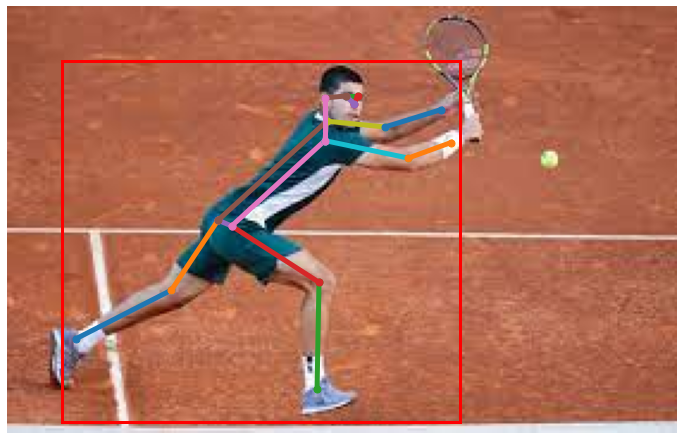

<Figure size 432x288 with 0 Axes>

In [ ]:
demo.show(show_bboxes=True, save=True)

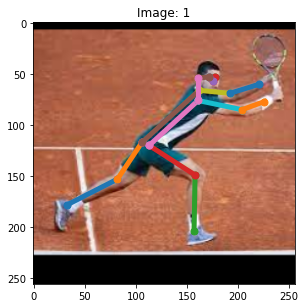

In [ ]:
demo.show_separate()

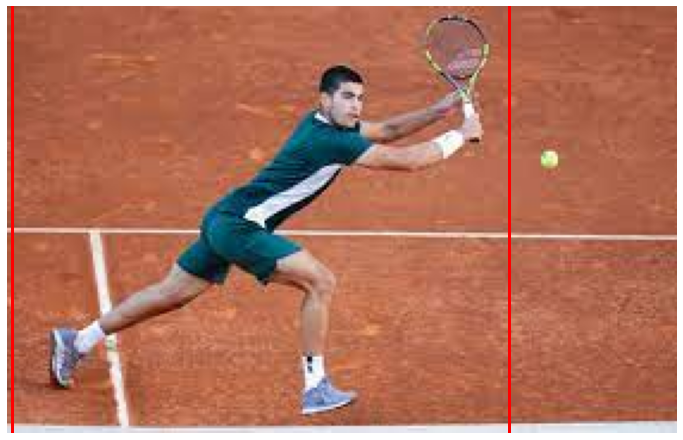

In [ ]:
demo.show_bboxes(show_square_bboxes=True)

In [ ]:
overlay = demo.create_overlay(show_bboxes=True)

In [ ]:
print(type(overlay))
print(overlay.shape)

<class 'numpy.ndarray'>
(179, 281, 4)


(179, 281, 4)
(179, 281, 4)


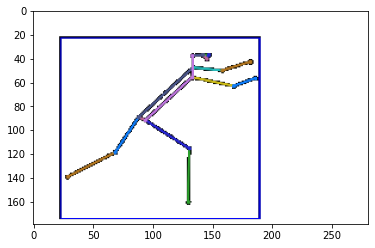

In [ ]:
plt.imshow(overlay)
print(overlay.shape)
print(overlay.shape)

In [10]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL

In [11]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: RGB image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [12]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  image = js_to_image(data) 
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # convert to BGR
  demo.detect(image)
  demo.show(show_bboxes=True)

<IPython.core.display.Javascript object>

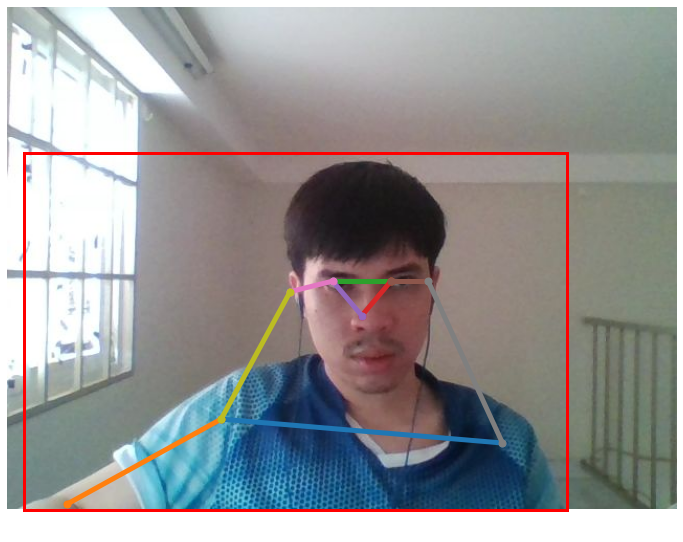

In [ ]:
take_photo()

In [13]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { 
            facingMode: "environment",
            frameRate:{ideal:5, max: 10}
            }});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [14]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    image = js_to_image(js_reply["img"])


    demo.detect(image)
    overlay = demo.create_overlay(show_bboxes=True) # should a be np.array
    # update bbox so next frame gets new overlay
    bbox_bytes = bbox_to_bytes(overlay)
    bbox = bbox_bytes

<IPython.core.display.Javascript object>